In [5]:
import pandas as pd
import numpy as np

# Load snapshot saved from attack simulation notebook beofore
df = pd.read_csv("spoofed_lidar_snapshot.csv")

hit_distances = df["Distance"].to_numpy()
ground_truth_labels = df["Label"].to_numpy()
ray_indices = np.arange(len(hit_distances))


In [6]:
# Treat all rays (even spoofed) as "real" for detection
# This simulates what a robot would do without knowing which ones are fake rays

window = 4
anomaly_threshold = 0.3
num_rays = len(hit_distances)

# Start with everyone as real
detected_labels = ["real"] * num_rays

for i in range(num_rays):
    neighbors = []
    for j in range(max(0, i - window), min(num_rays, i + window + 1)):
        if j != i and ground_truth_labels[j] == "real" and hit_distances[j] > 0:
            neighbors.append(hit_distances[j])
    if len(neighbors) < 2:
        neighbors = hit_distances[(ground_truth_labels == "real") & (hit_distances > 0)]
    if len(neighbors) > 0 and ground_truth_labels[i] != "none" and hit_distances[i] > 0:
        local_avg = np.mean(neighbors)
        deviation = abs(hit_distances[i] - local_avg)
        if deviation > anomaly_threshold:
            detected_labels[i] = "detected"


In [10]:
# Count metrics
TP = FP = FN = TN = 0

for i in range(num_rays):
    gt = ground_truth_labels[i]
    pred = detected_labels[i]

    if gt == "spoofed" and pred == "detected":
        TP += 1
    elif gt == "spoofed" and pred != "detected":
        FN += 1
    elif gt != "spoofed" and pred == "detected":
        FP += 1
    elif gt != "spoofed" and pred != "detected":
        TN += 1

# Compute metrics
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall = TP / (TP + FN) if (TP + FN) > 0 else 0

print("=== Evaluation Summary ===")
print(f"True Positives  (TP): {TP}")
print(f"False Positives (FP): {FP}")
print(f"False Negatives (FN): {FN}")
print(f"True Negatives  (TN): {TN}")
print()
print(f"Precision: {precision:.2f}")
print(f"Recall:    {recall:.2f}")


=== Evaluation Summary ===
True Positives  (TP): 5
False Positives (FP): 0
False Negatives (FN): 0
True Negatives  (TN): 55

Precision: 1.00
Recall:    1.00


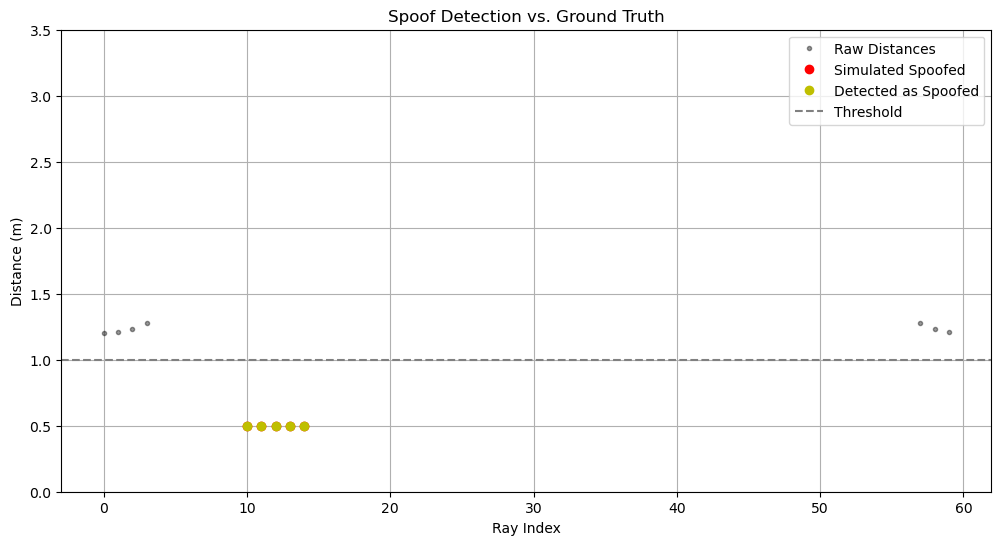

In [11]:
import matplotlib.pyplot as plt

spoofed = ground_truth_labels == "spoofed"
detected = np.array(detected_labels) == "detected"

plt.figure(figsize=(12, 6))
plt.plot(hit_distances, 'k.', alpha=0.4, label='Raw Distances')
plt.plot(ray_indices[spoofed], hit_distances[spoofed], 'ro', label='Simulated Spoofed')
plt.plot(ray_indices[detected], hit_distances[detected], 'yo', label='Detected as Spoofed')

plt.axhline(1.0, color='gray', linestyle='--', label='Threshold')
plt.title("Spoof Detection vs. Ground Truth")
plt.xlabel("Ray Index")
plt.ylabel("Distance (m)")
plt.ylim(0, 3.5)
plt.legend()
plt.grid(True)
plt.show()


In [12]:
spoofed_mask = (ground_truth_labels == "spoofed") | (ground_truth_labels == "sim_spoof")


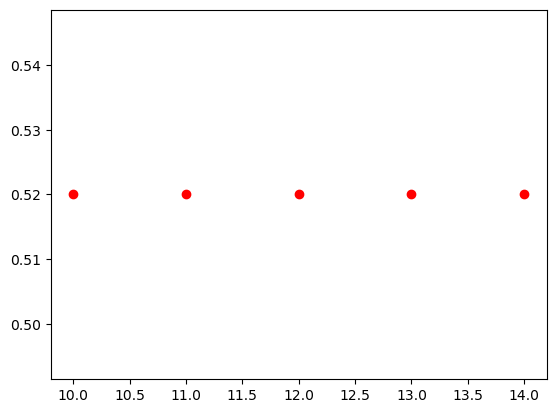

In [13]:
plt.plot(ray_indices[spoofed_mask], hit_distances[spoofed_mask] + 0.02, 'ro', label='Simulated Spoofed')


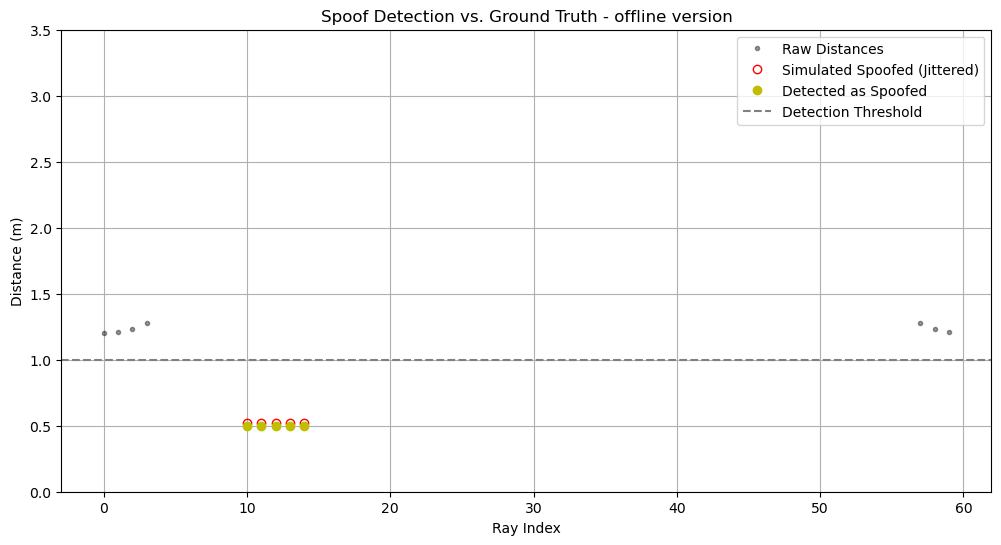

In [15]:
import matplotlib.pyplot as plt

# Define masks for the plot
real_mask = ground_truth_labels == "real"
spoofed_mask = (ground_truth_labels == "spoofed") | (ground_truth_labels == "sim_spoof")
missed_mask = ground_truth_labels == "none"
detected_mask = np.array(detected_labels) == "detected"

plt.figure(figsize=(12, 6))
plt.plot(ray_indices, hit_distances, 'k.', alpha=0.4, label='Raw Distances')
plt.plot(ray_indices[spoofed_mask], hit_distances[spoofed_mask] + 0.02, 'ro', markerfacecolor='none', label='Simulated Spoofed (Jittered)')
plt.plot(ray_indices[detected_mask], hit_distances[detected_mask], 'yo', label='Detected as Spoofed')
plt.axhline(1.0, color='gray', linestyle='--', label='Detection Threshold')

plt.title("Spoof Detection vs. Ground Truth - offline version")
plt.xlabel("Ray Index")
plt.ylabel("Distance (m)")
plt.ylim(0, 3.5)
plt.legend()
plt.grid(True)
plt.show()
